In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import pickle
import os
import keras_tuner as kt
import matplotlib.pyplot as plt
tf.config.set_visible_devices([], 'GPU')

In [8]:
rank = 'platinum'
with open(f'data/matches/{rank}.ds', 'rb') as f:
    data = pickle.load(f)

In [17]:
train_x, train_y = (data['training'][0], data['training'][1])
test_x, test_y = (data['testing'][0][0], data['testing'][0][1])

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_x)

In [12]:
tf.print(train_x[0].shape)

TensorShape([251])


In [5]:
def model_builder(hp):
    model = keras.Sequential()
    
    model.add(normalizer)
    
    for i in range(hp.Int('num_layers', 2, 14, step=1)):
        model.add(layers.Dense(
            units=hp.Int('units_' + str(i), 32, 512, step=8),
            kernel_initializer=hp.Choice('kernel_init_' + str(i), ['lecun_normal', 'lecun_uniform', 'he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal']),
            kernel_regularizer=regularizers.l2(0.001),
            bias_initializer='zeros',
            activation=hp.Choice('activation_' + str(i), ['relu', 'elu', 'selu', 'sigmoid'])))
        if i % 3 == 0:
            model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0.1, 0.8, sampling='linear')))
            model.add(layers.BatchNormalization())
    model.add(layers.Dense(1))
    
    optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4]))
    loss=losses.BinaryCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[keras.metrics.BinaryAccuracy()])
    return model

In [7]:
tuner = kt.tuners.RandomSearch(
    model_builder,
    objective='val_binary_accuracy',
    max_trials=1000,
    executions_per_trial=5,
    directory='kt_models',
    project_name='winpredictor'
)
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 14, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 8, 'sampling': 'linear'}
kernel_init_0 (Choice)
{'default': 'lecun_normal', 'conditions': [], 'values': ['lecun_normal', 'lecun_uniform', 'he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'], 'ordered': False}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'sigmoid'], 'ordered': False}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 8, 'sampling': 'linear'}
kernel_init_1 (Choice)
{'default': 'lecun_normal', 'conditions': [], 'values': ['lecun_normal', 'lecun_uniform', 'he_uniform', 'he_normal', 'glorot_unif

In [ ]:
tuner.search(train_x[:10000], train_y[:10000], batch_size=32, validation_split=0.1)

Trial 700 Complete [00h 00m 52s]
val_binary_accuracy: 0.6650000214576721

Best val_binary_accuracy So Far: 0.8461999773979187
Total elapsed time: 04h 46m 20s

Search: Running Trial #701

Value             |Best Value So Far |Hyperparameter
12                |2                 |num_layers
224               |448               |units_0
glorot_uniform    |lecun_uniform     |kernel_init_0
sigmoid           |sigmoid           |activation_0
0.42814           |0.33979           |dropout_0
360               |264               |units_1
glorot_normal     |lecun_normal      |kernel_init_1
relu              |elu               |activation_1
0.0001            |0.0001            |learning_rate
120               |360               |units_2
lecun_uniform     |he_normal         |kernel_init_2
elu               |selu              |activation_2
264               |368               |units_3
he_uniform        |he_normal         |kernel_init_3
relu              |selu              |activation_3
0.12465        

In [26]:
model = keras.Sequential()
model.add(normalizer)
model.add(layers.Dense(50, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(30, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(10, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1))
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=keras.metrics.BinaryAccuracy()
)

In [27]:
tf.math.reduce_sum(train_y) / train_y.shape[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.501045584006194>

In [28]:
history = model.fit(train_x, train_y, batch_size=512, validation_split=0.01, epochs=20)

Epoch 1/20
1119/1119 [==============================] - 2s 1ms/step - loss: 0.4757 - binary_accuracy: 0.7376 - val_loss: 0.4110 - val_binary_accuracy: 0.7793
Epoch 2/20
1119/1119 [==============================] - 1s 1ms/step - loss: 0.3428 - binary_accuracy: 0.8320 - val_loss: 0.3018 - val_binary_accuracy: 0.8557
Epoch 3/20
1119/1119 [==============================] - 2s 1ms/step - loss: 0.2604 - binary_accuracy: 0.8797 - val_loss: 0.2456 - val_binary_accuracy: 0.8915
Epoch 4/20
1119/1119 [==============================] - 2s 1ms/step - loss: 0.2095 - binary_accuracy: 0.9071 - val_loss: 0.2042 - val_binary_accuracy: 0.9100
Epoch 5/20
1119/1119 [==============================] - 2s 1ms/step - loss: 0.1758 - binary_accuracy: 0.9244 - val_loss: 0.1778 - val_binary_accuracy: 0.9228
Epoch 6/20
1119/1119 [==============================] - 2s 1ms/step - loss: 0.1505 - binary_accuracy: 0.9367 - val_loss: 0.1520 - val_binary_accuracy: 0.9355
Epoch 7/20
1119/1119 [==============================

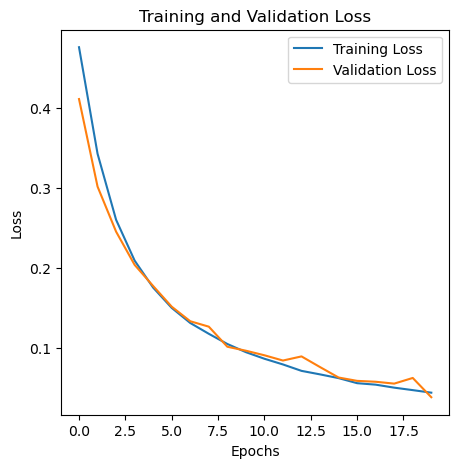

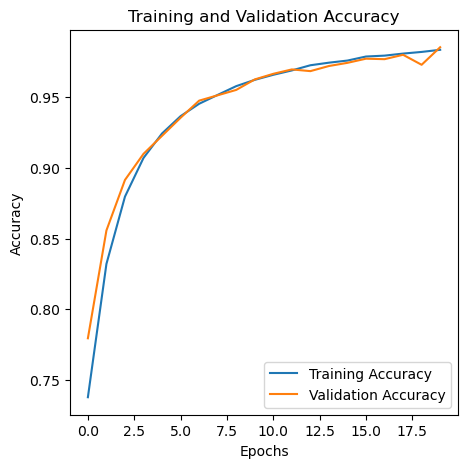

In [29]:
history_dic = history.history
history_dic.keys()

plt.figure(figsize=(5, 5))
plt.plot(history_dic['loss'], label='Training Loss')
plt.plot(history_dic['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history_dic['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dic['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
dupes = 0
for i in range(train_x.shape[0]):
    for j in range(train_x.shape[0]):
        if j != i and is_same(train_x[i], train_x[j]):
            print('gottem')
            dupes+=1
print(dupes)

In [30]:
loss, accuracy = model.evaluate(test_x, test_y)
print('Loss:', loss)
print('Accuracy:', accuracy)

11/11 [==============================] - 0s 600us/step - loss: 0.1178 - binary_accuracy: 0.9459
Loss: 0.11778512597084045
Accuracy: 0.945868968963623


In [80]:
export_model = keras.Sequential([
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)
export_model.save('live-model.h5')